# Face Recognition Using Siamese Network


Import the required libraries

In [1]:
import re
import numpy as np
from PIL import Image

from sklearn.model_selection import train_test_split
from keras import backend as K
from keras.layers import Activation
from keras.layers import Input, Lambda, Dense, Dropout, Convolution2D, MaxPooling2D, Flatten
from keras.models import Sequential, Model
from keras.optimizers import RMSprop

Now, we define a function for reading our input image. The function read_image takes input as an image and returns the numpy array.

In [2]:
!unzip Data.zip

Archive:  Data.zip
   creating: Data/faces_dataset/
   creating: Data/faces_dataset/s1/
  inflating: Data/faces_dataset/s1/1.pgm  
  inflating: Data/faces_dataset/s1/10.pgm  
  inflating: Data/faces_dataset/s1/2.pgm  
  inflating: Data/faces_dataset/s1/3.pgm  
  inflating: Data/faces_dataset/s1/4.pgm  
  inflating: Data/faces_dataset/s1/5.pgm  
  inflating: Data/faces_dataset/s1/6.pgm  
  inflating: Data/faces_dataset/s1/7.pgm  
  inflating: Data/faces_dataset/s1/8.pgm  
  inflating: Data/faces_dataset/s1/9.pgm  
   creating: Data/faces_dataset/s10/
  inflating: Data/faces_dataset/s10/1.pgm  
  inflating: Data/faces_dataset/s10/10.pgm  
  inflating: Data/faces_dataset/s10/2.pgm  
  inflating: Data/faces_dataset/s10/3.pgm  
  inflating: Data/faces_dataset/s10/4.pgm  
  inflating: Data/faces_dataset/s10/5.pgm  
  inflating: Data/faces_dataset/s10/6.pgm  
  inflating: Data/faces_dataset/s10/7.pgm  
  inflating: Data/faces_dataset/s10/8.pgm  
  inflating: Data/faces_dataset/s10/9.pgm  
   

In [3]:
!nvidia-smi

Thu Apr 11 20:39:08 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
def read_image(filename, byteorder='>'):

    # First, we read the image as a raw file into the buffer
    with open(filename, 'rb') as f:
        buffer = f.read()

    # Using regex, we extract the header, width, height, and maxval of the image
    header, width, height, maxval = re.search(
        rb"(^P5\s(?:\s*#.*[\r\n])*" +
        rb"(\d+)\s(?:\s*#.*[\r\n])*" +
        rb"(\d+)\s(?:\s*#.*[\r\n])*" +
        rb"(\d+)\s(?:\s*#.*[\r\n]\s)*)", buffer).groups()

    # Then, we convert the image to a numpy array using np.frombuffer which interprets the buffer as a one-dimensional array
    return np.frombuffer(buffer,
                         dtype='u1' if int(maxval) < 256 else byteorder+'u2',
                         count=int(width)*int(height),
                         offset=len(header)).reshape((int(height), int(width)))


For an example, Let us open one image,

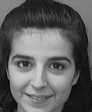

In [5]:
Image.open("/content/Data/faces_dataset/s10/1.pgm")

When we feed this image to our read_image function, it will return as the numpy array,

In [6]:
img = read_image('/content/Data/faces_dataset/s10/1.pgm')

In [7]:
img.shape

(112, 92)

Next, we'll create a function named `generate_pairs` to prepare our dataset for training. For the Siamese network to work effectively, it requires data to be structured as pairs, each labeled as either genuine (matching pair) or impostor (non-matching pair).

To begin, we select two images from the same folder, label this pair as genuine by adding it to the `x_genuine_pair` array, and set their corresponding label in `y_genuine` to 1. We then choose two images from different folders, label this pair as an impostor, add it to the `x_impostor_pair` array, and set their label in `y_impostor` to 0.

In the final step, we merge the `x_genuine_pair` and `x_impostor_pair` into a single dataset `X`, and similarly combine `y_genuine` and `y_impostor` into a single label set `Y`.

In [8]:

def generate_pairs(resize_factor=2, total_pairs=10000):
    initial_image = read_image('/content/Data/faces_dataset/s1/1.pgm', 'rw+')
    initial_image = initial_image[::resize_factor, ::resize_factor]
    img_height, img_width = initial_image.shape

    # Initialize arrays to store image pairs and labels
    genuine_pairs = np.zeros([total_pairs, 2, 1, img_height, img_width])
    genuine_labels = np.ones([total_pairs, 1])
    impostor_pairs = np.zeros([total_pairs, 2, 1, img_height, img_width])
    impostor_labels = np.zeros([total_pairs, 1])

    for i in range(40):
        for j in range(total_pairs // 40):
            idx1, idx2 = np.random.choice(10, 2, replace=False)
            img1_path = f'/content/Data/faces_dataset/s{i+1}/{idx1+1}.pgm'
            img2_path = f'/content/Data/faces_dataset/s{i+1}/{idx2+1}.pgm'
            img1, img2 = read_image(img1_path, 'rw+')[::resize_factor, ::resize_factor], read_image(img2_path, 'rw+')[::resize_factor, ::resize_factor]
            pair_index = i * (total_pairs // 40) + j
            genuine_pairs[pair_index, 0, 0, :, :] = img1
            genuine_pairs[pair_index, 1, 0, :, :] = img2

    for k in range(total_pairs):
        idx1, idx2 = np.random.choice(40, 2, replace=False)
        img1_path = f'/content/Data/faces_dataset/s{idx1+1}/{(k % 10)+1}.pgm'
        img2_path = f'/content/Data/faces_dataset/s{idx2+1}/{(k % 10)+1}.pgm'
        img1, img2 = read_image(img1_path, 'rw+')[::resize_factor, ::resize_factor], read_image(img2_path, 'rw+')[::resize_factor, ::resize_factor]
        impostor_pairs[k, 0, 0, :, :] = img1
        impostor_pairs[k, 1, 0, :, :] = img2

    # Combine genuine and impostor pairs
    pair_data = np.concatenate([genuine_pairs, impostor_pairs], axis=0) / 255
    labels = np.concatenate([genuine_labels, impostor_labels], axis=0)

    return pair_data, labels


Now, we generate our data and check our data size. As you can see we have 20,000 data points, out of these 10,000 are genuine pairs and 10,000 are imposite pairs.

In [9]:
X, Y = generate_pairs()

In [10]:
X.shape

(20000, 2, 1, 56, 46)

In [11]:
Y.shape

(20000, 1)

Next, we split our data for training and testing with 75% training and 25% testing proportions:

In [12]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=.25)

Now that, we have successfully generated our data, we build our siamese network. First, we define the base network which is basically a convolutional network used for feature extraction. We build two convolutional layers with rectified linear unit (ReLU) activations and max pooling followed by flat layer.

In [13]:
def build_base_network(input_shape):

    seq = Sequential()

    nb_filter = [6, 12]
    kernel_size = 3


    # Convolutional Layer 1
    seq.add(Convolution2D(nb_filter[0], (kernel_size, kernel_size), input_shape=input_shape, padding='valid', data_format='channels_first'))
    seq.add(Activation('relu'))
    seq.add(MaxPooling2D(pool_size=(2, 2), data_format='channels_first'))
    seq.add(Dropout(.25))

    # Convolutional Layer 2
    seq.add(Convolution2D(nb_filter[1], (kernel_size, kernel_size), padding='valid', data_format='channels_first'))
    seq.add(Activation('relu'))
    seq.add(MaxPooling2D(pool_size=(2, 2), data_format='channels_first'))
    seq.add(Dropout(.25))


    #flatten
    seq.add(Flatten())
    seq.add(Dense(128, activation='relu'))
    seq.add(Dropout(0.1))
    seq.add(Dense(50, activation='relu'))
    return seq


Next, we feed the image pair, to the base network, which will return the embeddings that is, feature vectors:

In [14]:
input_dim = x_train.shape[2:]
img_a = Input(shape=input_dim)
img_b = Input(shape=input_dim)

In [15]:
base_network = build_base_network(input_dim)
feat_vecs_a = base_network(img_a)
feat_vecs_b = base_network(img_b)

These feat_vecs_a and feat_vecs_b are the feature vectors of our image pair. Next, we feed this feature vectors to the energy function to compute the distance between them, we use Euclidean distance as our energy function.

In [16]:
import tensorflow as tf


In [17]:
def euclidean_distance(vects):
    x, y = vects
    return tf.math.sqrt(tf.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [18]:
distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([feat_vecs_a, feat_vecs_b])

 Now, we set the epoch length to 13 and we use RMS prop for optimization and define our model.

In [19]:
epochs = 13
rms = RMSprop()

model = Model(inputs=[img_a, img_b], outputs=distance)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1, 56, 46)]          0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 1, 56, 46)]          0         []                            
                                                                                                  
 sequential (Sequential)     (None, 50)                   191618    ['input_1[0][0]',             
                                                                     'input_2[0][0]']             
                                                                                                  
 lambda (Lambda)             (None, 1)                    0         ['sequential[0][0]',      

Next, we define our loss function as contrastive_loss function and compile the model.

In [20]:
def contrastive_loss(y_true, y_pred):
    margin = 1
    square_pred = tf.math.square(y_pred)
    margin_square = tf.math.square(tf.math.maximum(margin - y_pred, 0))
    return tf.reduce_mean(y_true * square_pred + (1 - y_true) * margin_square)


In [21]:
model.compile(loss=contrastive_loss, optimizer=rms)

In [22]:
img_1 = x_train[:, 0]
img2 = x_train[:, 1]

In [23]:
model.fit([img_1, img2], y_train, validation_split=0.25, batch_size=64, verbose=2, epochs=epochs)


Epoch 1/13
176/176 - 9s - loss: 0.1953 - val_loss: 0.2064 - 9s/epoch - 50ms/step
Epoch 2/13
176/176 - 1s - loss: 0.1286 - val_loss: 0.1922 - 911ms/epoch - 5ms/step
Epoch 3/13
176/176 - 1s - loss: 0.0970 - val_loss: 0.1375 - 910ms/epoch - 5ms/step
Epoch 4/13
176/176 - 1s - loss: 0.0778 - val_loss: 0.0612 - 897ms/epoch - 5ms/step
Epoch 5/13
176/176 - 1s - loss: 0.0651 - val_loss: 0.0560 - 911ms/epoch - 5ms/step
Epoch 6/13
176/176 - 1s - loss: 0.0560 - val_loss: 0.0506 - 1s/epoch - 6ms/step
Epoch 7/13
176/176 - 1s - loss: 0.0500 - val_loss: 0.0440 - 902ms/epoch - 5ms/step
Epoch 8/13
176/176 - 1s - loss: 0.0450 - val_loss: 0.0501 - 895ms/epoch - 5ms/step
Epoch 9/13
176/176 - 1s - loss: 0.0410 - val_loss: 0.0300 - 909ms/epoch - 5ms/step
Epoch 10/13
176/176 - 1s - loss: 0.0387 - val_loss: 0.0310 - 895ms/epoch - 5ms/step
Epoch 11/13
176/176 - 1s - loss: 0.0356 - val_loss: 0.0224 - 889ms/epoch - 5ms/step
Epoch 12/13
176/176 - 1s - loss: 0.0329 - val_loss: 0.0239 - 1s/epoch - 7ms/step
Epoch 13/

Now, we make predictions with test data

In [24]:
pred = model.predict([x_test[:, 0], x_test[:, 1]])

157/157 [==============================] - 1s 4ms/step


In [25]:
def compute_accuracy(predictions, labels):
    return labels[predictions.ravel() < 0.5].mean()

Finally, we check our model accuracy.

In [26]:
compute_accuracy(pred, y_test)

0.9517477203647416